In [ ]:
# === 측정 클래스 ===

import time
from statistics import mean
import pandas as pd
import pymysql

class QueryBenchmark:
    def __init__(self, conn_params, query_template, thresholds, repeats=10):
        self.conn_params = conn_params  # DB 연결 정보를 딕셔너리로 저장
        self.query_template = query_template
        self.thresholds = thresholds
        self.repeats = repeats
        self.results = []

    def run(self):
        conn = pymysql.connect(**self.conn_params)
        try:
            with conn.cursor() as cursor:
                for threshold in self.thresholds:
                    times = []
                    for _ in range(self.repeats):
                        start = time.perf_counter()
                        cursor.execute(self.query_template, (threshold,))
                        cursor.fetchall()
                        elapsed = time.perf_counter() - start
                        times.append(elapsed)
                    self.results.append({
                        'threshold': threshold,
                        'times': times
                    })
        finally:
            conn.close()  # 자동으로 닫힘

    def summarize(self):
        summary = []
        for item in self.results:
            times = item['times']
            summary.append({
                'Threshold': item['threshold'],
                'Average Time (s)': round(mean(times), 6),
                'Min Time (s)': round(min(times), 6),
                'Max Time (s)': round(max(times), 6)
            })
        return pd.DataFrame(summary)

    def get_raw_data(self):
        return self.results

In [42]:
# === 측정용 공통 설정 ===
conn_params = {
    'host': 'localhost',
    'port': 3307,
    'user': 'testuser',
    'password': 'testpass',
    'database': 'testdb',
    'charset': 'utf8mb4',
    'cursorclass': pymysql.cursors.DictCursor
}

query_template = """
SELECT
    f.id AS feedId,
    u.id AS userId,
    f.content,
    (SELECT COUNT(*) FROM feed_likes l WHERE l.feed_id = f.id),
    (SELECT COUNT(*) FROM comment c WHERE c.feed_id = f.id AND c.deleted_at IS NULL),
    f.created_at
FROM feeds f
JOIN users u ON f.user_id = u.id
WHERE f.id < %s AND f.deleted_at IS NULL
ORDER BY f.created_at DESC
LIMIT 10;
"""

thresholds = [1_000_000, 500_000, 10_000]
repeats = 10


In [52]:
# === 1) 초기 상태 (인덱스 생성 전)===
bm = QueryBenchmark(conn_params, query_template, thresholds, repeats)

# 측정 결과를 변수에 담아두기
bm.run()
df_before = bm.summarize()                  # 첫 셀 예: before
raw_before = bm.get_raw_data()              # → 평균 외 개별 시간이 필요할 때
print(df_before)

   Threshold  Average Time (s)  Min Time (s)  Max Time (s)
0    1000000          2.427136      2.319670      3.006747
1     500000          1.113119      1.085971      1.261253
2      10000          0.002759      0.002347      0.004173


In [66]:
# === 2) ONLY COMMENT 인덱스만 추가 후 셀 ===
# CREATE INDEX idx_comment_feed_deleted ON comment(feed_id, deleted_at);

bm = QueryBenchmark(conn_params, query_template, thresholds, repeats)

# 측정 결과를 변수에 담아두기
bm.run()
df_after_comment = bm.summarize()
raw_after_comment = bm.get_raw_data()
print(df_after_comment)

   Threshold  Average Time (s)  Min Time (s)  Max Time (s)
0    1000000          0.214412      0.175364      0.413973
1     500000          0.092292      0.085442      0.139352
2      10000          0.002272      0.002086      0.002550


In [ ]:
# === 3) FEED 인덱스까지 추가 후 셀 ===
# CREATE INDEX idx_feeds_deleted_created ON feeds(deleted_at, created_at DESC);

bm = QueryBenchmark(conn_params, query_template, thresholds, repeats)

# 측정 결과를 변수에 담아두기
bm.run()
df_after_feeds = bm.summarize()
raw_after_feeds = bm.get_raw_data()
print(df_after_feeds)

   Threshold  Average Time (s)  Min Time (s)  Max Time (s)
0    1000000          0.001442      0.000809      0.005135
1     500000          0.282574      0.271605      0.310896
2      10000          0.002701      0.002136      0.006548


In [ ]:
# === 4) only FEED 인덱스만 ===
onlyFeedIndex = []
onlyFeedIndex.append(df_after_feeds)
onlyFeedIndex.append(raw_after_feeds)
"""
   Threshold  Average Time (s)  Min Time (s)  Max Time (s)
0    1000000          0.004362      0.000414      0.038642
1     500000          0.291520      0.269485      0.399829
2      10000          0.003236      0.002278      0.009490
"""
print(onlyFeedIndex, sep="/n")

[   Threshold  Average Time (s)  Min Time (s)  Max Time (s)                 조건
0    1000000          0.004362      0.000414      0.038642  after_index_feeds
1     500000          0.291520      0.269485      0.399829  after_index_feeds
2      10000          0.003236      0.002278      0.009490  after_index_feeds, [{'threshold': 1000000, 'times': [0.03864225000143051, 0.00107833300717175, 0.00047404199722222984, 0.0004175409849267453, 0.0005576249968726188, 0.00047104197437874973, 0.0005967920005787164, 0.0005291670095175505, 0.00044275002437643707, 0.0004139999800827354]}, {'threshold': 500000, 'times': [0.399829417001456, 0.2995965000009164, 0.2978519170137588, 0.2747515830269549, 0.27823579200776294, 0.2835409579856787, 0.2719870409928262, 0.26991683401865885, 0.27000591601245105, 0.26948533399263397]}, {'threshold': 10000, 'times': [0.009490249998634681, 0.0030424169963225722, 0.0025216670182999223, 0.0025919580075424165, 0.002445874997647479, 0.0026007920096162707, 0.002527791017200

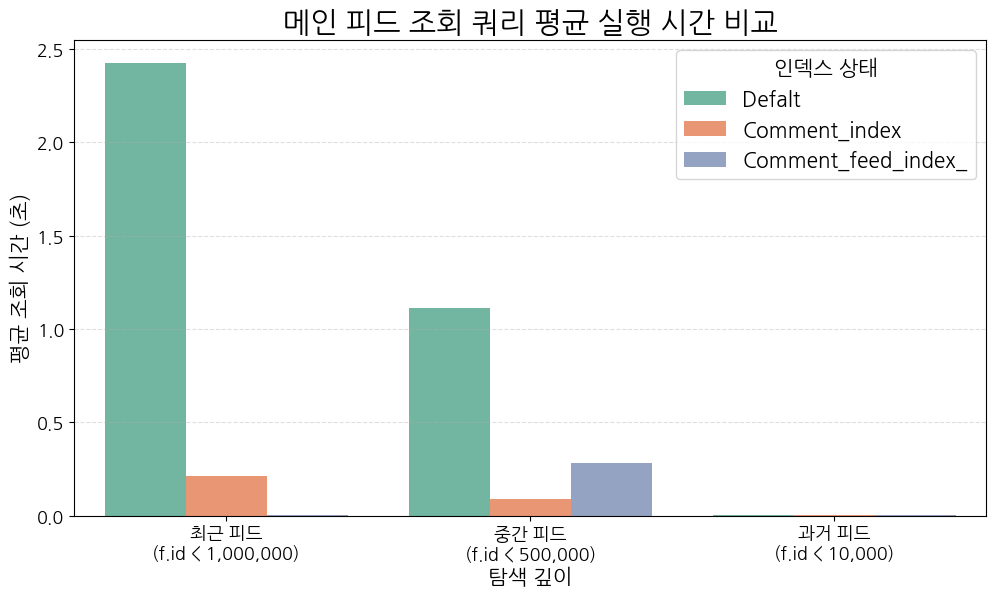

In [74]:
# === 결과 병합 및 시각화 ===

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd

# --- 한글 폰트 설정 (Notebook 환경용) ---
# plt.rcParams['font.family'] = 'AppleGothic'  # Mac 사용자
plt.rcParams['font.family'] = 'Nanum Gothic'

# 범래 이름 설정
df_before["조건"]         = "Defalt"
df_after_comment["조건"]  = "Comment_index"
df_after_feeds["조건"]    = "Comment_feed_index_"

df_total = pd.concat([df_before, df_after_comment, df_after_feeds], ignore_index=True)

# x축 가독성을 위해 Threshold 라벨 포맷
label_map = {
    1_000_000: "최근 피드\n(f.id < 1,000,000)",
    500_000: "중간 피드\n(f.id < 500,000)",
    10_000: "과거 피드\n(f.id < 10,000)"
}
df_total["Feed 범위"] = df_total["Threshold"].map(label_map)

# --- 평균 실행시간 막대 그래프 ---
plt.figure(figsize=(10,6))
sns.barplot(
    data=df_total,
    x="Feed 범위",            # 각 탐색 범위
    y="Average Time (s)",     # 평균 시간
    hue="조건",               # before / after...
    palette="Set2",
)
plt.title("메인 피드 조회 쿼리 평균 실행 시간 비교", fontsize=21)
plt.xlabel("탐색 깊이", fontsize=15)
plt.ylabel("평균 조회 시간 (초)", fontsize=15)
plt.legend(title="인덱스 상태", loc="upper right", fontsize=15, title_fontsize=15 )
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()